In [5]:
import sys 
import matplotlib.pyplot as plt
import numpy as np 
from numpy import sin, cos
from math import atan2
from time import sleep

sys.path.append("../")


from pydrake.geometry import StartMeshcat
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import PidController
from pydrake.all import LogVectorOutput


from src.plant.PRR import PlanarPRR
from src.mapping.PRR_theta import PlanarPRR_Theta

from src.controller.CartesianContrellerEE import CartesianController
from src.utils import save_diagram_svg, visualize

In [6]:

class PlanarPRR(LeafSystem):

    def __init__(self):

        LeafSystem.__init__(self)

        self.M = np.zeros((3, 3))
        self.C = np.zeros((3))
        self.ActuationMatrix = np.zeros((3, 2))
        self.Jac = np.zeros((3, 3))

        group_index = self.DeclareContinuousState(6)

        self.DeclareVectorInputPort("F", BasicVector(2))
        self.DeclareStateOutputPort("state", group_index)

        
        self.init_dynamic_model_parameters()


    def DoCalcTimeDerivatives(self, context:Context, derivatives_out:ContinuousState):

        fx, fy = self.get_input_port(0).Eval(context)
        F = np.array([fx, fy])
        state = context.get_continuous_state_vector()

        
        dq1, dq2, dq3 = state[3], state[4], state[5]
        self.eval_dyn_model(state_vect=state)
        
        q_dot = np.array([dq1, dq2, dq3])
        q_dot_dot = np.linalg.inv(self.M) @ ((self.ActuationMatrix @ F) - self.C)
        derivatives = np.concatenate( (q_dot, q_dot_dot) )
        derivatives_out.get_mutable_vector().SetFromVector(derivatives)

    def init_dynamic_model_parameters(self):

        self.m = [1, 1, 1]
        self.I = [1, 1, 1]
        self.d = [None, 0.5, 0.5]
        self.l = [None, 1, 1]  # the first is none because is q1
        
        self.a1 = self.m[0] + self.m[1] + self.m[2]
        self.a2 = self.I[1] + self.m[1] * (self.d[1]**2) + self.m[2]*(self.l[2]**2)
        self.a3 = self.I[2] + self.m[2] * (self.d[2]**2)
        self.a4 = self.m[2] * self.d[2]
        self.a5 = self.m[1] * self.d[1] + self.m[2] * self.l[1]

    def eval_dyn_model(self, state_vect):
        self._eval_M_of_q(state_vect)
        self._eval_C_of_q(state_vect)
        self._eval_actuation_matrix(state_vect)

    def _eval_M_of_q(self, state_vect):

        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]
        
        self.M[0, 0] =  self.a1
        self.M[0, 1] = -self.a5 * sin(q2)  - self.a4 * sin(q2 + q3)
        self.M[0, 2] = -self.a4 * sin(q2 + q3)

        self.M[1, 0] = -self.a5 * sin(q2) - self.a4 * sin(q2 + q3)
        self.M[1, 1] = self.a2 + self.a3 + 2*self.a4 * self.l[1] * cos(q3)
        self.M[1, 2] = self.a3 + self.a4 * self.l[1] * cos(q3)

        self.M[2, 0] = -self.a4 * sin(q2 + q3)
        self.M[2, 1] = self.a3 + self.a4 * self.l[1] * cos(q3)
        self.M[2, 2] = self.a3

    def _eval_C_of_q(self, state_vect):
    
        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]
        dq1, dq2, dq3 = state_vect[3], state_vect[4], state_vect[5]

        self.C[0] = (-self.a5*cos(q2) + self.a4*cos(q2+q3))*(dq2**2) - self.a4*cos(q2+q3)*dq3*(dq2 + dq3)
        self.C[1] = -self.a4 * self.l[1] * sin(q3) * dq3 * (2*dq2 + dq3)
        self.C[2] = self.a4 * self.l[2] * sin(q3) * (dq2**2)

    def _eval_actuation_matrix(self, state_vect):

        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]

        self.ActuationMatrix[0, 0]  = 1
        self.ActuationMatrix[0, 1]  = 0 
        
        self.ActuationMatrix[1, 0] = -self.l[1] * sin(q2) - self.l[2] * sin(q2 + q3)
        self.ActuationMatrix[1, 1] = -self.l[1] * cos(q2) - self.l[2] * cos(q2 + q3)
        
        self.ActuationMatrix[2, 0] = -self.l[1] * sin(q2) 
        self.ActuationMatrix[2, 1] = -self.l[1] * cos(q2)

class PlanarPRR_forward_kin(LeafSystem):

    def __init__(self):
        LeafSystem.__init__(self)

        self.Jac = np.zeros((3, 3))
        self.l = np.array([None, 1, 1])

        self.DeclareVectorInputPort('q_state', BasicVector(6))
        self.DeclareVectorOutputPort('EndEffector_state', BasicVector(4), self.CalcForwardAndDiffKinematic)

    def CalcForwardAndDiffKinematic(self, context, theta_state):

        q_state = self.get_input_port(0).Eval(context)
        q = np.array([q_state[0], q_state[1], q_state[2]])
        q_dot = np.array([q_state[3], q_state[4], q_state[5]])

        self.eval_jac(q)
        theta_1, theta_2 = self.forward_kin(q)
        theta_1_dot, theta_2_dot, _ = self.Jac @ q_dot
        theta_state.SetFromVector([theta_1, theta_2, theta_1_dot, theta_2_dot])
        print(f"x_ee: {theta_1}, y_ee: {theta_2}")


    def eval_jac(self, q): 
        
        q1, q2, q3 = q[0], q[1], q[2]

        self.Jac[0] = [1, -self.l[1]*sin(q2) - self.l[2]*sin(q2+q3), - self.l[2]*sin(q2+q3)]
        self.Jac[1] = [0, self.l[1]*cos(q2) + self.l[2]*cos(q2+q3), self.l[2]*cos(q2+q3)]
        self.Jac[2] = [0, 1, 1]
    
    def forward_kin(self, q):
        q1, q2, q3 = q[0], q[1], q[2]

        theta_1 = q1 + self.l[1]*cos(q2) + self.l[2]*cos(q2+q3)
        theta_2 = self.l[1]*sin(q2) + self.l[2]*sin(q2+q3)

        return theta_1, theta_2

class PlanarPRR_inTheta(PlanarPRR):

    def __init__(self):

        PlanarPRR.__init__(self)
        
        self.M_of_theta = np.zeros((3, 3))
        self.C_of_theta = np.zeros((3))
        self.ActuationMatrix = np.array([[1, 0], [0, 1], [0, 0]])
        self.Jac_h = np.zeros((3, 3))
        self.Jac_h_dot = np.zeros((3, 3))
    
    def eval_dyn_model(self, state_theta): 
        state_q = self.inverse_mapping(state_theta)
        self._eval_M_of_q(state_q)
        self._eval_C_of_q(state_q)
        self._eval_jac_h(state_q)
        self._eval_jac_h_dot(state_q)
        self._eval_M_of_theta(state_q)

    def inverse_mapping(self, state_theta) -> np.array:
        
        theta_dot = np.array([state_theta[3], state_theta[4], state_theta[5]])
        q3 = state_theta[2]
        q2 = atan2(state_theta[1], state_theta[0]) - atan2(self.l[2]*sin(q3), self.l[1] + self.l[2]*cos(q3))
        q1 = state_theta[0] - self.l[1]*cos(q2) - self.l[2]*cos(q2+q3)
        q_vect = np.array([q1, q2, q3])
       
        if not (theta_dot == np.zeros(3) ).all():
          q_vect_dot = np.linalg.inv(self.Jac_h) @ theta_dot
        else:
            q_vect_dot = np.zeros(3)

        return np.concatenate( (q_vect, q_vect_dot) )
    

    def _eval_M_of_theta(self, state_in_q):
        inv_jac_h = np.linalg.inv(self.Jac_h)
        self.M_of_theta = inv_jac_h.T @ self.M @ inv_jac_h

    def _eval_jac_h(self, state_in_q):

        q2, q3 = state_in_q[1], state_in_q[2]
        
        self.Jac_h[0, 0] = 1
        self.Jac_h[0, 1] = -self.l[1]*sin(q2) - self.l[2]*sin(q2+q3)
        self.Jac_h[0, 2] = -self.l[2]*sin(q2+q3)
        self.Jac_h[1, 0] = 0
        self.Jac_h[1, 1] = self.l[1]*cos(q2) + self.l[2]*cos(q2+q3)
        self.Jac_h[1, 2] = self.l[2]*cos(q2+q3)
        self.Jac_h[2, 0] = 0
        self.Jac_h[2, 1] = 0
        self.Jac_h[2, 2] = 1

    def _eval_jac_h_dot(self, state_in_q): 

        q2, q3 = state_in_q[1], state_in_q[2]
        q2dot, q3dot = state_in_q[4], state_in_q[5]

        self.Jac_h_dot[0, 0] = 0
        self.Jac_h_dot[0, 1] = -self.l[1]*cos(q2)*q2dot - self.l[2]*cos(q2+q3)*q2dot*q3dot
        self.Jac_h_dot[0, 2] = - self.l[2]*cos(q2+q3)*q2dot*q3dot

        self.Jac_h_dot[1, 0] = 0
        self.Jac_h_dot[1, 1] = -self.l[1]*sin(q2)*q2dot - self.l[2]*sin(q2+q3)*q2dot*q3dot
        self.Jac_h_dot[1, 2] = - self.l[2]*sin(q2+q3)*q2dot*q3dot

        self.Jac_h_dot[2, 0] = 0
        self.Jac_h_dot[2, 1] = 0
        self.Jac_h_dot[2, 2] = 0

    def DoCalcTimeDerivatives(self, context:Context, derivatives_theta:ContinuousState):

            fx, fy = self.get_input_port(0).Eval(context)
            F = np.array([fx, fy])

            state_theta = context.get_continuous_state_vector()
            theta_dot_1, theta_dot_2, theta_dot_3 = state_theta[3], state_theta[4], state_theta[5]

            self.eval_dyn_model(state_theta)
            # forma di stato ?? 
            theta_dot = np.array([theta_dot_1, theta_dot_2, theta_dot_3])
            theta_dot_dot = (np.linalg.inv(self.M_of_theta) @ self.ActuationMatrix @ F ) 
            + (self.Jac_h_dot @ np.linalg.inv(self.Jac_h) @ theta_dot) + self.C
            # output 
            derivatives = np.concatenate( (theta_dot, theta_dot_dot) )
            derivatives_theta.get_mutable_vector().SetFromVector(derivatives)
            
class PlanarPRR_theta_extractor(LeafSystem):
    
    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort('theta_state', BasicVector(6))
        self.DeclareVectorOutputPort('EE_state', BasicVector(4), self.extract_ee_state)

    def extract_ee_state(self, context, ee_state):
        theta_state = self.get_input_port().Eval(context)
        ee_state.SetFromVector( np.array([theta_state[0], theta_state[1], theta_state[3], theta_state[4] ]) )


PlanarPRR()
PlanarPRR_forward_kin()
PlanarPRR_inTheta()
PlanarPRR_theta_extractor()

NameError: name 'LeafSystem' is not defined

In [4]:
def plot_log(log_plant, log_controller, log_EE):

    plt.figure()
    times = log_plant.sample_times()

    q1, q2, q3, dq1, dq2, dq3 = log_plant.data()
    EE_x, EE_y, EE_x_dot, EE_y_dot = log_EE.data()
    fx, fy = log_controller.data()

    fig, axis = plt.subplots(3, 2)

    axis[0, 0].plot(times, q1, label='q1')
    axis[0, 0].plot(times, q2, label='q2')
    axis[0, 0].plot(times, q3, label='q3')
    axis[0, 0].set_title('joint variable')
    axis[0, 0].grid()
    axis[0, 0].legend()

    axis[0, 1].plot(times, dq1, label='q1_dot')
    axis[0, 1].plot(times, dq2, label='q2_dot')
    axis[0, 1].plot(times, dq3, label='q3_dot')
    axis[0, 1].set_title("joint velocity")
    axis[0, 1].grid()
    axis[0, 1].legend()

    
    axis[1, 0].plot(times, EE_x, label="EE_x")
    axis[1, 0].plot(times, EE_y, label='EE_y')
    axis[1, 0].set_title("EE position")
    axis[1, 0].legend()
    axis[1, 0].grid()

    axis[1, 1].plot(times, EE_x_dot, label="EE_x_dot")
    axis[1, 1].plot(times, EE_y_dot, label='EE_y_dot')
    axis[1, 1].set_title("EE velocity")
    axis[1, 1].legend()
    axis[1, 1].grid()


    axis[2, 0].plot(times, fx, label="fx")
    axis[2, 0].plot(times, fy, label='fy')
    axis[2, 0].set_title("controller output")
    axis[2, 0].legend()
    axis[2, 0].grid()

    plt.tight_layout()
    plt.show()



In [3]:
def simulate_original_system(simulation_time_step):
    
    builder = DiagramBuilder()
    
    plant = builder.AddSystem(PlanarPRR())
    controller = builder.AddSystem(CartesianController())
    #controller = builder.AddSystem(PidController(kp=[1, 1], ki=[0.5, 0.5], kd=[2., 2.]))
 
    logger_joint = LogVectorOutput(plant.GetOutputPort('state'), builder)
    logger_EE = LogVectorOutput(plant.GetOutputPort('EE_state'), builder)
    logger_controller = LogVectorOutput(controller.GetOutputPort('F'), builder)

    builder.Connect(plant.GetOutputPort('EE_state'), controller.GetInputPort('actual_state'))
    builder.Connect(controller.GetOutputPort('F'), plant.GetInputPort("F"))
  

    diagram = builder.Build()
 
    root_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(root_context)
    controller_context = controller.GetMyContextFromRoot(root_context)

    plant_context.SetContinuousState([0, 0, 0, 0, 0, 0])

    controller.GetInputPort('desired_state').FixValue(controller_context, np.array([1, 1 , 0, 0]))


    simulatore = Simulator(diagram, root_context)
    simulatore.AdvanceTo(simulation_time_step)


    log_joint = logger_joint.FindLog(root_context)
    log_controller = logger_controller.FindLog(root_context)
    log_EE = logger_EE.FindLog(root_context)
    
    return log_joint, log_controller, log_EE
   
log_joint, log_controller, log_EE = simulate_original_system(0.3)
plot_log(log_joint, log_controller, log_EE)



NameError: name 'plot_log' is not defined

In [2]:
def simulate_Theta_system(desired_state, simulation_time):
    
    builder = DiagramBuilder()
    
    plant = builder.AddSystem(PlanarPRR_Theta())
    controller = builder.AddSystem(CartesianController(kp=40, kd=50))
    #controller = builder.AddSystem(PidController(kp=[1, 1], ki=[0.5, 0.5], kd=[2., 2.]))
 
    logger_joint = LogVectorOutput(plant.GetOutputPort('q_vect'), builder)
    logger_EE = LogVectorOutput(plant.GetOutputPort('EE_state'), builder)
    logger_controller = LogVectorOutput(controller.GetOutputPort('F'), builder)

    builder.Connect(plant.GetOutputPort('EE_state'), controller.GetInputPort('actual_state'))
    builder.Connect(controller.GetOutputPort('F'), plant.GetInputPort("F"))
  

    diagram = builder.Build()
 
    root_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(root_context)
    controller_context = controller.GetMyContextFromRoot(root_context)

    plant_context.SetContinuousState(plant.forward_mapping(np.zeros(6)))

    controller.GetInputPort('desired_state').FixValue(controller_context, desired_state)


    simulatore = Simulator(diagram, root_context)
    simulatore.AdvanceTo(simulation_time)


    log_joint = logger_joint.FindLog(root_context)
    log_controller = logger_controller.FindLog(root_context)
    log_EE = logger_EE.FindLog(root_context)
    
    return log_joint, log_controller, log_EE
   


<Figure size 640x480 with 0 Axes>

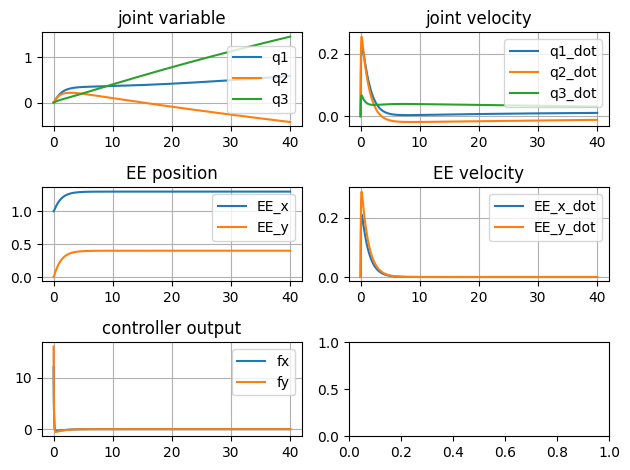

In [5]:
sim_time = 40
desired_state = np.array([1.3,0.4,0,0])
log_joint, log_controller, log_EE = simulate_Theta_system(desired_state, simulation_time=sim_time)
plot_log(log_joint, log_controller, log_EE)

In [6]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [7]:
visualize(
    meshcat, 
    robot_sdf_path='../sdf_model/PRR_planar.sdf',
    q_state_vect=log_joint.data().T, 
    rate=sim_time/log_joint.num_samples()
)

In [9]:

from pydrake.systems.framework import DiagramBuilder
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.geometry import MeshcatVisualizer
from pydrake.multibody.parsing import Parser

from manipulation.scenarios import AddMultibodyTriad


In [10]:
meshcat.Delete()
robot_sdf_path='../sdf_model/PRR_planar.sdf',

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
Parser(plant, scene_graph).AddModels("../sdf_model/PRR_planar.sdf")
plant.Finalize()
BODY_NAMES = ['q1_parent', 'q2_parent', 'q3_parent']
for body_name in BODY_NAMES:
    AddMultibodyTriad(plant.GetFrameByName(body_name), scene_graph)

visualizer = MeshcatVisualizer.AddToBuilder(
            builder,
        scene_graph.get_query_output_port(),
        meshcat
)

diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
plant_context.SetDiscreteState([0,0,0,0,0,0])
diagram.ForcedPublish(context)
